In [63]:
import pandas as pd
import pymysql
db_info = pymysql.connect(user='root', passwd='root',host='localhost',port=3306, db='test')
cursor = db_info.cursor()

In [64]:
def user_log_data():
    cursor.execute("SELECT * FROM user_log")

    result = []
    for c in cursor:
        res = dict()
        res['reg_time'] = c[1]
        res['user_id'] = c[2]
        res['book_id'] = c[3]
        result.append(res)
    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)


def book_data():
    cursor.execute("SELECT * FROM book")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[0]
        res['category_id'] = c[4]
        result.append(res)

    return pd.DataFrame(result)


def user_category_data():
    cursor.execute("SELECT * FROM user_category")

    result = []
    for c in cursor:
        res = dict()
        res['user_id'] = c[1]
        res['user_category_id'] = c[2]
        result.append(res)

    return pd.DataFrame(result)


def review_data():
    cursor.execute("SELECT * FROM review")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[5]
        res['user_id'] = c[4]
        res['rank'] = c[1]
        res['reg_time'] = c[3]
        res['content'] = c[2]
        result.append(res)

    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)

In [65]:
user_log = user_log_data()
user_category = user_category_data()
book = book_data()
review = review_data()

In [66]:
data1 = pd.merge(user_log[["book_id","user_id"]], review, how="left", on=["book_id","user_id"])
data1['content'].fillna('',inplace=True)

data1['content'] = data1['content'].str.replace(pat=r'[^A-Za-z0-9가-힣 ]', repl= r'', regex=True).str.strip()
data1['rank'].fillna(int(data1['rank'].mean()),inplace=True)
data1 = pd.merge(data1, book, on="book_id")
data1

,book_id,user_id,rank,reg_time,content,category_id
0,9153,19738,6,2021-09-30,귀여운 남자에게 빠질뻔 했네,2551
1,9153,266,10,2021-09-24,진짜 가볍게 도서관책으로 봤는데 너무 예쁜 그림체에 매력적인 캐릭터들이 초딩 때 본...,2551
2,9153,1188,10,2021-09-24,풋풋하당,2551
3,9153,3213,10,2021-09-23,잔잔하면서 웃음 BL 일락말락하여 BL 싫어하는 나도 거부감없이 재밌게 읽음 특히 ...,2551
4,9153,19760,6,2021-09-18,내용은 가볍디 가벼운 남고생들의 이야기다 화풍은 취향을 많이 타는 편이라서 언급하지...,2551
...,...,...,...,...,...,...
41297,6311,16493,10,2020-01-01,아흑 기다리기 넘 힘듭니다빨리 받아보구 싶어요 로빈이쌤 쪼꼬미들 기대만땅,1230
41298,12591,6638,8,2020-01-01,다양한 삶의 형태와 그 형태를 만들어 가는 인생 여행기,55889
41299,12428,21644,10,2020-01-01,문장제는 처음 구매합니다 기억의 계산법 연산은 계속 구매해오던더라 잘 이용하고 있어...,50246
41300,5508,6638,8,2020-01-01,다양한 삶의 형태와 그 형태를 만들어 가는 인생 여행기,1196


In [54]:
# def cate_coding(x):
#     for cate in x['user_category_id']:
#         x['c_'+str(cate)] = 1
#     return x

# user_category['user_category_id'] = user_category['user_category_id'].astype(str)
# user_cate = user_category.groupby('user_id').agg(lambda x: ' '.join(set(x)))
# user_cate['user_category_id'] = user_cate['user_category_id'].str.split(' ')


# cate_list = book['category_id'].unique()
# for cate in cate_list:
#     user_cate['c_' + str(cate)] = 0

# user_cate = user_cate.apply(cate_coding,axis=1)

# user_pre_cate = user_cate.drop('user_category_id',axis=1)

# user_see_cate = data1.pivot_table(values='rank',index='user_id',columns='category_id').fillna(0)

In [81]:
%%time

from sklearn.preprocessing import MultiLabelBinarizer

user_category['user_category_id'] = user_category['user_category_id'].astype(str)
user_cate = user_category.groupby('user_id').agg(lambda x: ' '.join(set(x)))
user_cate['user_category_id'] = user_cate['user_category_id'].str.split(' ')


cate_list = book['category_id'].unique()
for cate in cate_list:
    user_cate['c_' + str(cate)] = 0
    
mlb = MultiLabelBinarizer()
user_cate[user_cate.columns[1:]] = mlb.fit_transform(user_cate['user_category_id'])
user_cate.drop('user_category_id',axis=1, inplace=True)
user_see_cate = data1.groupby(['user_id','category_id'])['rank'].mean().unstack().fillna(0)
user_see_cate


Wall time: 478 ms


category_id,1,74,170,336,351,517,656,798,987,1108,...,4395,8257,13789,17195,50246,55889,55890,76000,76001,112011
user_id,,,,,,,,,,,,,,,,,,,,,
1,10.0,10.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0
2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,9.5,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
23835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
23836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [68]:
user_cate = pd.concat([user_cate, user_see_cate],axis=1).fillna(0)
user_cate

,c_1,c_74,c_170,c_336,c_351,c_517,c_656,c_798,c_987,c_1108,...,4395,8257,13789,17195,50246,55889,55890,76000,76001,112011
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23834,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
23835,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
23836,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

stopword= ' '.join([line.rstrip('\n') for line in open('stopwords-ko.txt', 'r',encoding="utf-8")])

tfidf = TfidfVectorizer(stop_words='english',max_features=300)

tfidf_matrix = tfidf.fit_transform(data1['content'])

In [70]:
tfidf_data = pd.DataFrame(tfidf_matrix.toarray(),index=data1['user_id']).reset_index()
tfidf_g_data = tfidf_data.groupby('user_id').mean()
user_cate_tf = pd.concat([user_cate, tfidf_g_data],axis=1).fillna(0)

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3,random_state=0)
pca.fit(user_cate_tf)
pca_samples = pca.transform(user_cate_tf)
ps = pd.DataFrame(pca_samples, index=user_cate_tf.index)

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot')

In [73]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(ps)
    scores.append(silhouette_score(ps, kmeans.labels_))


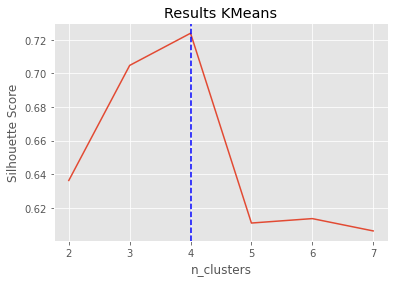

In [74]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

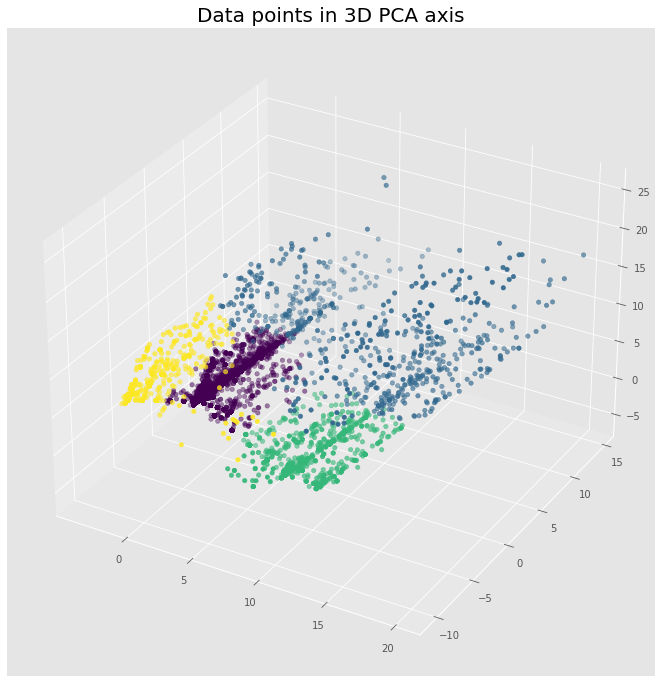

In [75]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(ps)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ps[0], ps[2], ps[1], c=kmeans.labels_)

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

In [76]:
pred = kmeans.predict(ps.loc[1,:].to_frame().T)
user_cate_tf['cluster'] = kmeans.labels_
user_cate_tf_cluster = user_cate_tf[user_cate_tf['cluster']==pred[0]].drop('cluster',axis=1)

In [77]:
user_cate_tf['cluster'].value_counts()

0    18266
2     2810
3     2029
1      733
Name: cluster, dtype: int64

In [82]:
user_log_my = user_log[user_log['user_id'].isin(user_cate_tf_cluster.index)]
user_cate_my = user_category.query()
my_book = pd.merge(user_log_my[["book_id","user_id"]], review, on=["book_id","user_id"])
my_book_rank = my_book.pivot_table(values='rank',index='user_id',columns='book_id').fillna(0)
my_book_rank = my_book.groupby(['user_id','book_id'])["rank"].mean().unstack().fillna(0)
not_books = book[~book['book_id'].isin(user_log_my["book_id"].unique())]
not_books = not_books[not_books['category_id'].isin(user_log_my["book_id"].unique())]

SyntaxError: invalid syntax (<ipython-input-82-c90ae83bdbba>, line 2)

In [38]:
my_book_rank[not_books.to_list()] = 0

KeyboardInterrupt: 

In [213]:
cursor.close()